# Journal plot figure

In [1]:
import sys
sys.path.append('/afs/ipp/u/daguiam/development/ricglibrary')
sys.path.append('/afs/ipp/u/daguiam/development/ricgcalibrate')
sys.path.append('/afs/ipp/aug/ads-diags/common/python/lib')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors


#import ricg
#from ricgcalibrate import *
#from ricgcalibrate.ricg_calibrate import *
import scipy.signal

import pandas as pd
%matplotlib inline
import argparse

from test_cases import all_ricg_shots as ricgshots
from test_cases import test_cases
from test_cases import test_cases_extra

import pickle
from scipy import constants as konst

class dict2obj(dict):
    def __init__(self, d, default=None):
        self.__d = d
        self.__default = default
        super(self.__class__, self).__init__(d)

    def __getattr__(self, k):
        if k in self.__d:
            v = self.__d[k]
            if isinstance(v, dict):
                v = self.__class__(v)
            setattr(self, k, v)
            return v
        return self.__default


saving


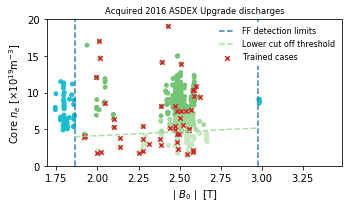

In [3]:
test_cases = test_cases + test_cases_extra
#parser = argparse.ArgumentParser(description='Plots multiple relevant data figures of all shotnumbers')

#parser.add_argument('-nr','--number',help='Number of tests to plot',required=False,default=0)
#parser.add_argument('-new','--new',help='Get new data from journal instead of trying to read locally',required=False,action='store_true',default=False)
#parser.add_argument('-shot','--shot',help='Plot shotnumbers annotations',required=False,action='store_true',default=False)


#args = parser.parse_args()

#nrplot= int(args.number)
#getnew= args.new
#plotshot= args.shot

nrplot = 0
getnew = False
plotshot = False


if nrplot == 0:
    nrplot = -1


testshotnumbers = []
for test in test_cases:
    testshotnumbers.append(test[0])

data_dir = 'data/'
filepickle = data_dir+'journaldata.pickle'



try:
    data = pickle.load(open(filepickle,'rb'))

except:
    print ' No data file present'
    getnew = True
    
data = dict2obj(data)
data.ne = data.ne/1e19

def calc_ne(fpe2):
    return fpe2*4*konst.pi*konst.epsilon_0*konst.m_e/(konst.e*konst.e)

# Calculates the electron cyclotron frequency from a given Magnetic Field
def calc_fce(bfield):
    return np.abs(konst.e*bfield/(2*konst.pi*konst.m_e))

# Calculates the magnetic field from a given electron cyclotron frequency
def calc_bfield(fce):
    return (fce*2*konst.pi*konst.m_e)/(konst.e)

minf=40e9
maxf=64e9
rgeo = 1.65
rant = 2.15


minb = calc_bfield(minf)
maxb = calc_bfield(maxf)

k1a = 4*np.power(konst.pi,2) * konst.epsilon_0  / np.power(konst.e,2)



minb = minb*rant/rgeo
maxb = maxb*rant/rgeo



bvec = np.linspace(-3,3,200)

bvec2 = np.linspace(minb,maxb,200)
bvec=bvec2

fcevec = calc_fce(bvec*rgeo/rant)
#print fcevec
#Calculating minimum measureable density
fpe2min = np.power(minf-fcevec/2,2)-np.power(fcevec,2)/4
fpe2min[np.where(fpe2min<0)]=np.NaN
nemin = calc_ne(fpe2min)/1e19


#Calculating maximum measureable density
fpe2min = np.power(minf+fcevec/2,2)-np.power(fcevec,2)/4
fpe2min[np.where(fpe2min<0)]=np.NaN
nemin = calc_ne(fpe2min)/1e19

fpe2max = np.power(maxf+fcevec/2,2)-np.power(fcevec,2)/4
nemax = calc_ne(fpe2max)/1e19

# calculate there is a measureable lower cutoff
fpe2lc = np.power(minf-fcevec/2,2)-np.power(fcevec,2)/4
nelc = calc_ne(fpe2lc)/1e19

fc = minf
def calc_ne_uc(fc,fce):
    ne= k1a * konst.m_e* fc*(fc - fce)
    #print ne
    #ne[np.where(ne<0)] = 0
    return ne

def calc_ne_lc(fc,fce):
    ne= k1a * konst.m_e* fc*(fc + fce)
    if ne.size>1:
        ne[np.where(ne<0)] = 0
    return ne

#fcevec[np.where(fcevec<=minf)] = np.nan
#fcevec[np.where(fcevec>=maxf)] = np.nan


neuc = calc_ne_uc(minf,fcevec)/1e19
nelc = calc_ne_lc(minf,fcevec)/1e19
nelcmax = calc_ne_lc(fcevec,fcevec)/1e19

#print neuc
#print nelc


data.bt = np.abs(data.bt)

color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

cortests = color[3]
corbar = color[0]


cm = plt.cm.get_cmap('Vega20c')
cm_skip = [cm.colors[i] for i in range(len(cm.colors))]

coruc = cm_skip[11]
coruclc = cm_skip[10]
corlc = cm_skip[9]

#coruc = cm_skip[10]
#coruclc = cm_skip[9]
#corlc = cm_skip[8]


coruntested = color[9]
alphaval = 0.9


#fig = plt.figure()
#ax = fig.add_subplot(111)

f,axarr = plt.subplots(1,1,figsize=(5,3))
plt.subplots_adjust(left=0.15, bottom=0.15, right=None, top=None, wspace=0.05, hspace=0)

ax = axarr


testedshotsidx = np.in1d(data.shotnumber,testshotnumbers)
nottestedshotsidx = np.logical_not(testedshotsidx)
if plotshot:
    for i,xy in enumerate(zip(data.bt,data.ne)):
        pass
        if testedshotsidx[i]:
            ax.annotate('%d'%(data.shotnumber[i]),xy =xy,textcoords='data',fontsize='x-small',color='Gray')


plt.axvline(x=minb, ymin=0, ymax=1,color=corbar,linestyle='--',label='FF detection limits',alpha=alphaval)
#plt.axvline(x=-minb, ymin=0, ymax=1,color='b',linestyle='--',linewidth=0.5,label='minb')

plt.axvline(x=maxb, ymin=0, ymax=1,color=corbar,linestyle='--',alpha=alphaval)


#plt.axvline(x=-maxb, ymin=0, ymax=1,color='b',linestyle='--',linewidth=0.5,label='maxb')

bt = np.abs(data.bt)
totaldata = len(bt)

#rgeo = 1.50
#rant = 2.2
c = ['LightGray']*totaldata
c = [coruntested]*totaldata





idx_notmeasured = []
idx_uconly = []
idx_smalllc = []
idx_largelc = []




for i in range(totaldata):
    a = 'LightGreen'
    
    if bt[i] > maxb or bt[i] < minb:
        #print minb,bt[i],maxb
        idx_notmeasured.append(i)
        continue
    
    
    if data.ne[i] > calc_ne_lc(
                                calc_fce(bt[i]*rgeo/rant),
                                 calc_fce(bt[i]*rgeo/rant))/1e19: 
        a = 'DarkGreen'
        c[i] = corlc
        idx_largelc.append(i)
        continue
    if data.ne[i] > calc_ne_lc(minf,calc_fce(bt[i]*rgeo/rant))/1e19: 
        a = 'Green'
        c[i] = coruclc
        idx_smalllc.append(i)
        continue

    idx_uconly.append(i)
    a = 'LightGreen'
    a = coruntested
    c[i] = coruc
    


# Plotting


idxrange = range(len(data.bt))
#for idx in [idx_notmeasured,idx_uconly,idx_smalllc,idx_largelc]:
#    maskidx = np.in1d(idxrange,idx)
#    plt.scatter(np.abs(data.bt[maskidx]),data.ne[maskidx],c=c[maskidx],edgecolor='#262626',s=50,lw=0.3,alpha=0.6)
#plt.scatter(np.abs(data.bt),data.ne,c=c,s=15,label='Acquired shots')
plt.scatter(np.abs(data.bt),data.ne,c=c,s=15)





#plt.scatter(data.bt[nottestedshotsidx],data.ne[nottestedshotsidx],c='b')



#plt.plot(bvec,nemin,label='nemin')
#plt.plot(bvec,nemax,label='nemax')
plt.plot(bvec,nelc,c=coruclc,linestyle='--',label='Lower cut off threshold',alpha=alphaval)
#plt.plot(bvec,nelcmax,c=corlc,linestyle='--',label='',alpha=alphaval)
plt.legend(fontsize='small')
#plt.plot(bvec,neuc,'r',label='neuc')

plt.xlabel(r'$\mid B_0\mid$ [T]')
plt.ylabel(r'Core $n_e$ [$\times10^{19}$m$^{-3}$]')

plt.xlim([1.69,3.49])
plt.ylim([0,20])

plt.title('Acquired 2016 ASDEX Upgrade discharges',fontsize='small')

filename = 'images/fig_journal_notests.pdf'
plt.savefig(filename,dpi=300)


plt.scatter(data.bt[testedshotsidx],data.ne[testedshotsidx],c=cortests,s=20,label='Trained cases',marker='x')

plt.legend(fontsize='8',loc=1).get_frame().set_edgecolor('w')

#print testshotnumbers
#plt.grid()


plt.tight_layout()
#plt.subplots_adjust(hspace=0.05, wspace=0.05)
print 'saving'
filename = 'images/fig_journal_nn.pdf'
plt.savefig(filename,dpi=300)

plt.show()



[[33520,
  [0.5,
   1.25,
   1.62,
   1.926,
   2.25,
   2.6,
   2.93,
   3.27,
   2.08,
   2.45,
   2.75,
   3.07,
   3.45,
   3.58,
   3.98,
   4.25,
   4.6,
   3.78,
   4.1,
   4.47,
   4.8,
   4.98,
   5.1,
   5.25,
   5.45]],
 [33523,
  [0.5,
   1.25,
   1.62,
   1.926,
   2.25,
   2.6,
   2.93,
   3.27,
   2.08,
   2.45,
   2.75,
   3.07,
   3.45,
   3.58,
   3.98,
   4.25,
   4.6,
   3.78,
   4.1,
   4.47,
   4.8,
   4.98,
   5.1,
   5.25,
   5.45]],
 [33105,
  [0.5,
   0.76,
   1.35,
   1.93,
   2.26,
   2.43,
   2.69,
   3.15,
   3.589,
   6.28,
   4.16,
   4.48,
   4.87,
   5.39,
   5.89,
   6.28,
   6.75,
   7.19,
   7.62,
   8.2,
   8.8]],
 [33673,
  [0.4,
   0.68,
   0.5,
   0.87,
   1.24,
   2.777,
   2.779,
   2.78,
   2.781,
   2.879,
   2.884,
   4.4079,
   4.4075,
   4.0797,
   4.40871,
   4.40962,
   4.4109,
   7.189,
   6.67,
   7.148]],
 [33292,
  [0.44,
   0.65,
   0.897,
   0.745,
   1.02,
   1.178,
   1.286,
   1.39,
   1.48,
   1.69,
   2,
   2.129,
   3.89,
  